 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#4.1-MODIS-LAI-product" data-toc-modified-id="4.1-MODIS-LAI-product-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>4.1 MODIS LAI product</a></span><ul class="toc-item"><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Binary-data" data-toc-modified-id="Binary-data-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Binary data</a></span></li></ul></ul></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Exercise-4.1" data-toc-modified-id="Exercise-4.1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise 4.1</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Downloading-data" data-toc-modified-id="Downloading-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Downloading data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#NASA-EarthData" data-toc-modified-id="NASA-EarthData-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>NASA EarthData</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Direct-downloading" data-toc-modified-id="Direct-downloading-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Direct downloading</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Exercise-A-Different-Dataset" data-toc-modified-id="Exercise-A-Different-Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercise A Different Dataset</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Download" data-toc-modified-id="Download-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Download</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Explore" data-toc-modified-id="Explore-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Explore</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Read-a-dataset" data-toc-modified-id="Read-a-dataset-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Read a dataset</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Water-mask" data-toc-modified-id="Water-mask-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Water mask</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Valid-pixel-mask" data-toc-modified-id="Valid-pixel-mask-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Valid pixel mask</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#3D-dataset" data-toc-modified-id="3D-dataset-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>3D dataset</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#4.3-Vector-masking" data-toc-modified-id="4.3-Vector-masking-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>4.3 Vector masking</a></span></li><li><span><a href="http://localhost:8888/notebooks/Chapter4_GDAL/GDAL_HDF.ipynb#Exercise-4.3" data-toc-modified-id="Exercise-4.3-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exercise 4.3</a></span></li></ul></div>

# Chapter 4. Geospatial data

In this session, we will introduced the `gdal` geospatial module which can read a wide range of scientific data formats. You will find that using it to read data is quite similar to the work we did last week on netCDF datasets.

<div class="alert alert-block alert-danger">

We haven't got much time to cover all the things GDAL does, but there's extra material provided, that you should at least **READ THROUGH**

See e.g. [Chapter4_GDAL/GDAL_Python_bindings.ipynb](Chapter4_GDAL/GDAL_Python_bindings.ipynb)
</div>


The main challenges are also much the same: very often, you need to be able to read data from a 'stack' of image files and generate a useful 3D (space and time) dataset from these. Once you have the data in such a form, there are *many* things we can do with it, and very many of these are convenient to do using array-based expressions such as in numpy (consider the simplicity of the expression `absorbed = rad * (1 - albedo)` from last week's exercise). 

That said, it can sometimes be quite an effort to prepare datasets in this form. Last week, we developed a 'valid data' mask from the GlobAlbedo dataset, as invalid data were stored as `nan`. Very often though, scientific datasets have more complex 'Quality Control' (QC) information, that gives per-pixel information describing the quality of the product at that location (e.g. it was very cloudy so the results are not so good).

To explore this, we will first consider the [MODIS Leaf Area Index (LAI)](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a2) product that is mapped at 1 km resolution, every 8 days from the year 2000.

We will learn how to read in these data (in `hdf` format) using `gdal`, and how to interpret the QC information in such products to produce valid data masks. As an exercise, you will wrap some code around that to form a 3D masked array of the dataset.

Next, we will consider how to download such data. This should be a reinforcement of material from last week, but it is useful to know how to conveniently access NASA data products. A challenge in the exercise then is to download a different dataset (MODIS snow cover) for the UK, and form a masked 3D dataset from this.

Finally, we will introduce vector datasets and show you python tools that allow you (among many other things) to build a mask in the projection and sampling of your spatial dataset (MODIS LAI in this case).

There are many features and as many complexities to the Python tools we will deal with today, but in this material, we cover some very typical tasks you will want to do. They all revolve around generating masked 3D datasets from NASA MODIS datasets, which is a very useful form of global biophysical information over the last decade+. We also provide much material for further reading and use when you are more confident in your programming.

A final point here is that the material we cover today is very closely related to what you will need to do in the first section of your assessed practical that we will introduce next week, so you really need to get to grips with this now.

There is not as much 'new' material as in previous weeks now, but we assume that you have understood, and can make use of, material from those lectures.

First, we will examine data from a NASA MODIS product on Leaf Area Index (LAI).

- 4.1 [MODIS LAI product](#4.1-MODIS-LAI-product)
- 4.2 [Downloading data](#4.2-Downloading-data)  
- 4.3 [Vector masking](#4.3-Vector-masking)

## 4.1 MODIS LAI product

GDAL covers a much wider set of file formats and methods than the netCDF library that we previously used.

Basic operation involves:

- load gdal 
- open a spatial dataset (an hdf format file here)
- specify which subsets you want.

We can explore the subsets in the file with `GetSubDatasets()`:

In [1]:
# how to find out which datasets are in the file

import gdal # Import GDAL library bindings
%matplotlib inline
import numpy as np
import pylab as plt

# The file that we shall be using
# Needs to be on current directory
filename = 'data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf'

g = gdal.Open(filename)
# g should now be a GDAL dataset, but if the file isn't found
# g will be none. Let's test this:
if g is None:
    print "Problem opening file %s!" % filename
else:
    print "File %s opened fine" % filename
    
    
subdatasets = g.GetSubDatasets()
for fname, name in subdatasets:
    print name
    print "\t", fname



File data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf opened fine
[1200x1200] Fpar_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Fpar_1km
[1200x1200] Lai_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Lai_1km
[1200x1200] FparLai_QC MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparLai_QC
[1200x1200] FparExtra_QC MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparExtra_QC
[1200x1200] FparStdDev_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparStdDev_1km
[1200x1200] LaiStdDev_1km MOD_Grid_MOD15A2 (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MCD15A2.A201

In the previous code snippet we have done a number of different things:

1. Import the GDAL library
2. Open a file with GDAL, storing a handler to the file in `g`
3. Test that `g` is not `None` (as this indicates failure opening the file. Try changing `filename` above to something else)
4. We then use the `GetSubDatasets()` method to read out information on the different subdatasets available from this file (compare to the output of `gdalinfo` on the shelf earlier)
5. Loop over the retrieved subdatasets to print the name (human-readable information) and the GDAL filename. This last item is the filename that you need to use to tell GDAL to open a particular data layer of the 6 layers present in this example

Let's say that we want to access the LAI information. By contrasting the output of the above code (or `gdalinfo`) to the contents of the [LAI/fAPAR product information page](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a2), we find out that we want the layers for `Lai_1km`, `FparLai_Qc`, `FparExtra_QC` and `LaiStdDev_1km`. 

To read these individual datasets, we need to open each of them individually using GDAL, and the GDAL filenames used above:

In [2]:
# How to access specific datasets in gdal

# Let's create a list with the selected layer names
selected_layers = [  "Lai_1km", "FparLai_QC", "LaiStdDev_1km" ]

# We will store the data in a dictionary
# Initialise an empty dictionary
data = {}

# for convenience, we will use string substitution to create a 
# template for GDAL filenames, which we'll substitute on the fly:
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
# This has two substitutions (the %s parts) which will refer to:
# - the filename
# - the data layer

for i, layer in enumerate ( selected_layers ):
    this_file = file_template % ( filename, layer )
    print "Opening Layer %d: %s" % (i+1, this_file )
    g = gdal.Open ( this_file )
    
    if g is None:
        raise IOError
    data[layer] = g.ReadAsArray() 
    print "\t>>> Read %s!" % layer
    

Opening Layer 1: HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:Lai_1km
	>>> Read Lai_1km!
Opening Layer 2: HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:FparLai_QC
	>>> Read FparLai_QC!
Opening Layer 3: HDF4_EOS:EOS_GRID:"data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf":MOD_Grid_MOD15A2:LaiStdDev_1km
	>>> Read LaiStdDev_1km!


In the previous code, we have seen a way of neatly creating the filenames required by GDAL to access the independent datasets: a template string that gets substituted with the `filename` and the `layer` name. Note that the presence of double quotes in the template requires us to use single quotes around it. The data is now stored in a dictionary, and can be accessed as e.g. `data['Lai_1km']` which is a numpy array:

In [3]:
type(data['Lai_1km'])

numpy.ndarray

In [4]:
print data['Lai_1km']

[[ 3  3  2 ...,  6  8 21]
 [ 4  3  6 ...,  8 18 14]
 [ 3 12 11 ..., 12  8  8]
 ..., 
 [ 2  3  2 ..., 18 11 17]
 [ 2  3  3 ..., 16 19 15]
 [ 3  2  2 ..., 15 16 15]]


Now we have to translate the LAI values into meaningful quantities. According to the [LAI](https://lpdaac.usgs.gov/products/modis_products_table/leaf_area_index_fraction_of_photosynthetically_active_radiation/8_day_l4_global_1km/mod15a2) webpage, there is a scale factor of 0.1 involved for LAI and SD LAI:

In [5]:
lai = data['Lai_1km'] * 0.1
lai_sd = data['LaiStdDev_1km'] * 0.1

In [6]:
print "LAI"
print lai
print "SD"
print lai_sd

LAI
[[ 0.3  0.3  0.2 ...,  0.6  0.8  2.1]
 [ 0.4  0.3  0.6 ...,  0.8  1.8  1.4]
 [ 0.3  1.2  1.1 ...,  1.2  0.8  0.8]
 ..., 
 [ 0.2  0.3  0.2 ...,  1.8  1.1  1.7]
 [ 0.2  0.3  0.3 ...,  1.6  1.9  1.5]
 [ 0.3  0.2  0.2 ...,  1.5  1.6  1.5]]
SD
[[ 0.2  0.2  0.1 ...,  0.2  0.1  0.3]
 [ 0.2  0.2  0.2 ...,  0.2  0.3  0.2]
 [ 0.   0.1  0.2 ...,  0.1  0.2  0.2]
 ..., 
 [ 0.1  0.1  0.1 ...,  0.3  0.   0.1]
 [ 0.1  0.1  0.1 ...,  0.2  0.2  0.1]
 [ 0.1  0.1  0.1 ...,  0.1  0.2  0.1]]


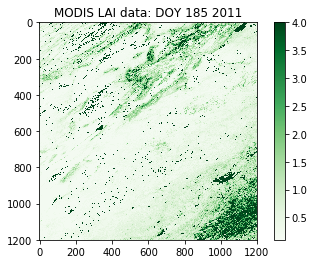

In [7]:
# plot the LAI

import pylab as plt
%matplotlib inline

# colormap
cmap = plt.cm.Greens

plt.imshow(lai,interpolation='none',vmin=0.1,vmax=4.,cmap=cmap)
plt.title('MODIS LAI data: DOY 185 2011')
plt.colorbar()

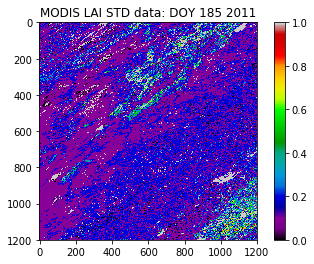

In [8]:
# plot the LAI std

import pylab as plt

# colormap
cmap = plt.cm.spectral
# this sets the no data colour. 'k' is black

plt.imshow(lai_sd,interpolation='none',vmax=1.,cmap=cmap)
plt.title('MODIS LAI STD data: DOY 185 2011')
plt.colorbar()

It is not possible to produce LAI estimates if it is persistently cloudy, so the dataset may contain some gaps.

These are identified in the dataset using the QC (Quality Control) information.

We should then examine this. 

The codes for this are also given on the LAI product page. They are described as bit combinations:

<table>
<tr>
<th>Bit No.</th>	<th>Parameter Name</th><th>	Bit Combination</th><th>Explanation</th>
<tr>
<td>0	</td><td>MODLAND_QC bits</td><td>	0</td><td>	Good quality (main algorithm with or without saturation)	 	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Other Quality (back-up algorithm or fill values)	 	 </td>
</tr>

<tr>
<td>1	</td><td>Sensor</td><td>	0</td><td>	TERRA</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>AQUA</td>
</tr>

<tr>
<td>2	</td><td>DeadDetector</td><td>	0</td><td>	Detectors apparently fine for up to 50% of channels 1	2	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	1	</td><td>Dead detectors caused >50% adjacent detector retrieval</td>
</tr>

<tr>
<td>3-4</td><td>CloudState</td><td>	00</td><td>	Significant clouds NOT present (clear)	 	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	01	</td><td>Significant clouds WERE present</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	10	</td><td>Mixed clouds present on pixel</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	11	</td><td>Cloud state not defined assumed clear</td>
</tr>

<tr>
<td>5-7</td><td>CF_QC</td><td>	000</td><td>	Main (RT) method used	best result possible (no saturation)	 </td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	001	</td><td>Main (RT) method used with saturation. Good	very usable</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	010	</td><td>Main (RT) method failed due to bad geometry	empirical algorithm used</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	011	</td><td> Main (RT) method failed due to problems other than geometry	empirical algorithm used</td>
</tr>
<tr>
<td>&nbsp;</td><td>&nbsp;</td><td>	100	</td><td> Pixel not produced at all	value coudn’t be retrieved (possible reasons: bad L1B data	unusable MODAGAGG data)</td>
</tr>
</table>

In using this information, it is up to the use which data he/she wants to pass through for any further processing. There are clearly trade-offs: if you look for only the highest quality data, then the number of samples is likely to be lower than if you were more tolerant. But if you are too tolerant, you will get spurious results. 



But let's just say that we want to use only the highest quality data. 

This means we want bit 0 to be 0 ...

Let's have a look at the QC data:

In [9]:
qc = data['FparLai_QC'] # Get the QC data which is an unsigned 8 bit byte
print qc , qc.dtype

[[2 2 0 ..., 0 2 2]
 [2 2 0 ..., 2 0 2]
 [0 2 0 ..., 0 0 0]
 ..., 
 [0 0 2 ..., 0 8 0]
 [0 0 0 ..., 0 0 2]
 [0 2 0 ..., 2 2 2]] uint8


We see various byte values:

In [10]:
np.unique(qc)

array([  0,   2,   8,  10,  16,  18,  32,  34,  40,  42,  48,  50,  97,
        99, 105, 107, 113, 115, 157], dtype=uint8)

In [11]:
# translated into binary using bin()
for i in np.unique(qc):
    print i,bin(i)

0 0b0
2 0b10
8 0b1000
10 0b1010
16 0b10000
18 0b10010
32 0b100000
34 0b100010
40 0b101000
42 0b101010
48 0b110000
50 0b110010
97 0b1100001
99 0b1100011
105 0b1101001
107 0b1101011
113 0b1110001
115 0b1110011
157 0b10011101


#### Binary data

Computers store data in base 2, rather than the more usual base 10. A byte contains 8 bits, which can either be 0 or 1. A number is made up of the sum of powers of two that are given a 1. The diagram below shows how the number 53 in base 10 is written as as 00110101 in base 2 (using 8 bits):

![Taken from[http://dustlayer.com/cpu-6510-articles/2013/4/18/math-basics-converting-numbering-systems](http://dustlayer.com/cpu-6510-articles/2013/4/18/math-basics-converting-numbering-systems)](https://static1.squarespace.com/static/511651d6e4b0a31c035e30aa/t/51713d9ce4b02974eba2db13/1366375836670/dustlayer.com-binary-to-decimal.png)

In the case of QA flags, the ability to indicate a yes/no or a small set of options (e.g. "Very good", "Good", "Bad" "Terrible") by position results in an efficient way to convey a lot of information. In the case of the LAI QA product, we have that number 53 (00110101) can be explained as

<dl>
    <dt>Bit 0 (rightmost bit) = 1</dt><dd> "Other" quality</dd>
    <dt>Bit 1 = 0 </dt><dd> Sensor is "TERRA"</dd>    
    <dt>Bit 2 = 1 </dt><dd> Dead detectors</dd>    
    <dt>Bits 3 and 4 = 10 </dt><dd>Mixed clouds present on pixel</dd>    
    <dt>Bit 5, 6 and 7 = 001 </dt><dd>Main (RT) method used with saturation. Good very usable</dd>    
</dl>

So we have encoded 5 very different and qualitative pieces of information in a very small amount of storage. In some cases, we might just be interested in checking one or a few of the flags. A simple way to achieve this is to use a logical AND (`&`) operation, where one would `AND` a template binary mask with the number. For example, if we wanted the third bit, we could use the number 0000100 (e.g. decimal 4):

    00110101 & 0000100 = 0000100
    53 & 4 = 4
    
This gives us the wanted bit in position 3 (so we can either get 4 or 0). We can then *shift* this number of the right by 3 units to have a 0 or a 1. In Python, we can do this by the binary right shift operator, `>>`:

    0000100 >> 2 = 00000001
    (53 & 4) >> 2 = 1
    
When operating on Numpy arrays, one has to operate with [special functions](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.bitwise.html) ``np.bitwise_and`` and ``np.right_shift``, which will operate on an element by element basis. 

Let's see what the different fields we found in the LAI product QA flagsfields mean by 

1. Finding the unique values in the `qc` array
2. Looping over them
3. Calculate the `AND` of the flag and a mask (in this case, we'll check bits 5-7 and bit 0)
4. Shifting the result of the `AND` operation right (if required)

We will be printing the results. To print the binary representation of  a number, we can use the format string `#010b` (which uses 0 bits, plus to extra bits for the `0b` at the beginning, and additionally does zero padding). You can read more about [Python string formatters here](https://docs.python.org/2/library/string.html#format-specification-mini-language).



In [12]:
mask_bits_57 = 0b11100000 # Or decimal 2**7 + 2**6 + 2**5 = 224
mask_bit_0 = 0b00000001 # Or decimal 1

for value in np.unique(qc):
    print "Value: {:03d}(->{:#010b}), flags 5-7: {:d}(->{:#010b}),flag 0: {:d}(->{:#010b})".format(
            value,
            value,
            value & mask_bits_57 >> 5, 
            value & mask_bits_57 >> 5, 
            value & mask_bit_0, 
            value & mask_bit_0)
    

Value: 000(->0b00000000), flags 5-7: 0(->0b00000000),flag 0: 0(->0b00000000)
Value: 002(->0b00000010), flags 5-7: 2(->0b00000010),flag 0: 0(->0b00000000)
Value: 008(->0b00001000), flags 5-7: 0(->0b00000000),flag 0: 0(->0b00000000)
Value: 010(->0b00001010), flags 5-7: 2(->0b00000010),flag 0: 0(->0b00000000)
Value: 016(->0b00010000), flags 5-7: 0(->0b00000000),flag 0: 0(->0b00000000)
Value: 018(->0b00010010), flags 5-7: 2(->0b00000010),flag 0: 0(->0b00000000)
Value: 032(->0b00100000), flags 5-7: 0(->0b00000000),flag 0: 0(->0b00000000)
Value: 034(->0b00100010), flags 5-7: 2(->0b00000010),flag 0: 0(->0b00000000)
Value: 040(->0b00101000), flags 5-7: 0(->0b00000000),flag 0: 0(->0b00000000)
Value: 042(->0b00101010), flags 5-7: 2(->0b00000010),flag 0: 0(->0b00000000)
Value: 048(->0b00110000), flags 5-7: 0(->0b00000000),flag 0: 0(->0b00000000)
Value: 050(->0b00110010), flags 5-7: 2(->0b00000010),flag 0: 0(->0b00000000)
Value: 097(->0b01100001), flags 5-7: 1(->0b00000001),flag 0: 1(->0b00000001)

So, for example (examining the table above) `105` is interpreted at `0b011` in fields 5 to 7 (which is 3 in decimal). This indicates that 'Main (RT) method failed due to problems other than geometry empirical algorithm used'. Here, bit zero is set to `1`, so this is a 'bad' pixel.

In this case, we are only interested in bit 0, which is an easier task than interpreting all of the bits.

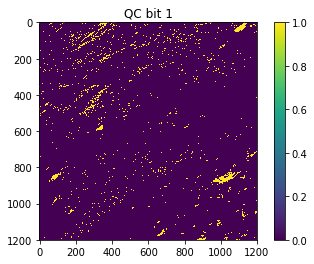

In [13]:
# the good data are where qc bit 1 is 0

qc = data['FparLai_QC'] # Get the QC data
# find bit 0
qc = np.bitwise_and(qc, 1)

plt.imshow(qc)
plt.title('QC bit 1')
plt.colorbar()

We can use this mask to generate a masked array. Masked arrays, as we have seen before, are like normal arrays, but they have an associated mask. 

Remember that the mask in a masked array should be `False` for good data, so we can directly use `qc` as defined above. 

We shall also choose another colormap (there are [lots to choose from](http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps)), and set values outside the 0.1 and 4 to be shown as black pixels.

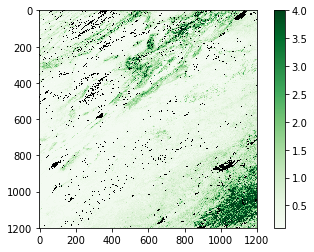

In [14]:
# colormap
cmap = plt.cm.Greens
cmap.set_bad ( 'k' )
# this sets the no data colour. 'k' is black

# generate the masked array
laim = np.ma.array ( lai, mask=qc )

# and plot it
plt.imshow ( laim, cmap=cmap, interpolation='none', vmin=0.1, vmax=4)
plt.colorbar()

Similarly, we can do a similar thing for Standard Deviation

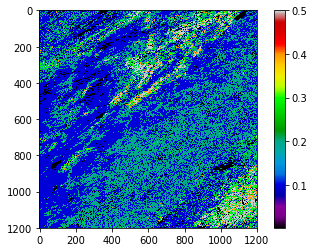

In [15]:
cmap = plt.cm.spectral
cmap.set_bad ( 'k' )
stdm = np.ma.array ( lai_sd, mask=qc )
plt.imshow ( stdm, cmap=cmap, interpolation='none', vmin=0.001, vmax=0.5)
plt.colorbar()

For convenience, we might wrap all of this up into a function:

In [16]:
import gdal
import numpy as np
import numpy.ma as ma


def getLAI(filename, \
           qc_layer = 'FparLai_QC',\
           scale = [0.1, 0.1],\
           selected_layers = ["Lai_1km", "LaiStdDev_1km"]):
           
    # get the QC layer too
    selected_layers.append(qc_layer)
    scale.append(1)
    # We will store the data in a dictionary
    # Initialise an empty dictionary
    data = {}
    # for convenience, we will use string substitution to create a 
    # template for GDAL filenames, which we'll substitute on the fly:
    file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
    # This has two substitutions (the %s parts) which will refer to:
    # - the filename
    # - the data layer
    for i,layer in enumerate(selected_layers):
        this_file = file_template % ( filename, layer )
        g = gdal.Open ( this_file )
        
        if g is None:
            raise IOError
        
        data[layer] = g.ReadAsArray() * scale[i]

    qc = data[qc_layer] # Get the QC data
    # find bit 0
    qc = np.bitwise_and( qc, 1)
    
    odata = {}
    for layer in selected_layers[:-1]:
        odata[layer] = ma.array(data[layer],mask=qc)
    
    return odata
    

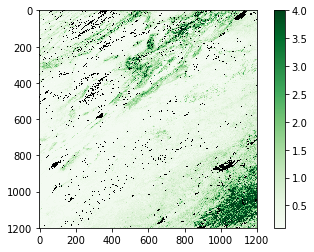

In [17]:
filename = 'data/MCD15A2.A2011185.h09v05.005.2011213154534.hdf'

lai_data = getLAI(filename)

# colormap
cmap = plt.cm.Greens
cmap.set_bad ( 'k' )
# this sets the no data colour. 'k' is black

# and plot it
plt.imshow ( lai_data['Lai_1km'], cmap=cmap, interpolation='nearest', vmin=0.1, vmax=4)
plt.colorbar()

## Exercise 4.1

You are given the MODIS LAI data files for the year 2012 in the directory `data` for the UK (MODIS tile h17v03).

Read these LAI datasets into a masked array, using QA bit 0 to mask the data (i.e. good quality data only) and generate a movie of LAI.

You should end up with something like:

![](files/images/lai_uk02.gif)

## Downloading data

For the exercise above, you were supplied with the datasets that were previously downloaded. But how would you go about downloading your own data?

### NASA EarthData

The easiest option would be to use NASA's own system for discovering and accessing data, [EarthData](https://search.earthdata.nasa.gov/search).
<div class="alert alert-block alert-danger">
Go to [EarthData](https://search.earthdata.nasa.gov/search) **NOW** and create a username/password combination
** YOU WILL NEED THESE TO DO THE COURSE ASSIGNMENT!**
</div>

We will be looking for data about snow cover, in particular the MODIS/TERRA snow cover product (product code MOD10A1) covering the UK. You would basically basically search for MOD10A1, select a start and end times, and maybe filter by tile (select `h17v03` in the *Granule Search* box). Then you can click on *Download data*. In the next screen, you would select *Direct Download*. You can then get a Download script that you can download and run (it will ask you for your username and password, and proceed to download the data), but you can also see that the URLs are of the form

```
https://n5eil01u.ecs.nsidc.org/DP5/MOST/MOD10A1.006/2016.12.15/MOD10A1.A2016350.h17v03.006.2016352154432.hdf
```
So maybe we can try downloading them with a script?

### Direct downloading

We have asceartained that the URLs have the following format:
```
https://n5eil01u.ecs.nsidc.org/DP5/MOST/MOD10A1.006/<date>/<hdf_file>
```

You can visit any date folder, and see the list of files. We can use the requests module for this. We will also use the `datetime` module to operate with dates. The `datetime` module allows you to work with time easily. In here, we'll be using it to create a date object using `datetime.datetime(year, month, day)`, a time increase (`datetime.timedelta(days=1)`), and to convert from a `datetime` object to a string with a particular format `datetime.strftime("%Y.%m.%d")`, which is the format that corresponds to `2001.12.31`, for example. 

We can then use requests to loop over each date, get the file listing, and filter it by MODIS tile (e.g. `h17v03` in our case), and select the files that have a `.hdf` extension, ignoring those that also have metadata (`.hdf.xml`).

The code to connect to the server and get the data is quite complicated, so we'll use a function provided below called `url_downloader`. You don't need to understand the details of the authentication, but you should be able to figure out what's happening in this bit of the code

```python
            if r.ok:
                for line in r.text.split("\n"):
                    if line.find("h17v03") >= 0 and line.find(".hdf") >= 0 and line.find(".xml") < 0:
                        fname = line.split("href")[1][1:].split('"')[1]
```




In [32]:
import os
import requests
import datetime
print """
########################################################################################
###  CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME!    ###
########################################################################################
"""
username = "profLewis"
password = "GeogG1222016"

def url_downloader (username, password, destination_folder="data/",
                    url="https://n5eil01u.ecs.nsidc.org/DP5/MOST/MOD10A1.006/2016.01.01/"):
    """Downloads data from a NASA URL, provided that a username/password pair exist.
    Parameters
    ----------
    username: str
        The NASA EarthData username
    password: str
        The NASA EarthData password
    destination_folder: str
        The destination folder
    url: str
        The required URL
    
    Returns
    --------
    A string with the location of the downloaded file.
    """
    with requests.Session() as session:
            session.auth = (username, password)
            r1 = session.request('get', url)
            r = session.get(r1.url, auth=(username, password))
            if r.ok:
                for line in r.text.split("\n"):
                    if line.find("h17v03") >= 0 and line.find(".hdf") >= 0 and line.find(".xml") < 0:
                        fname = line.split("href")[1][1:].split('"')[1]
            url_granule = url + fname
            r1 = session.request('get', url)
            r = session.get(r1.url, auth=(username, password))
            output_fname = os.path.join(destination_folder, fname)
            if r.ok:
                with open(output_fname, 'w') as fp:
                    fp.write(r.content)
            print "Saved file {}".format(output_fname)
            return output_fname

url_downloader (username, password)



########################################################################################
###  CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME! CHANGE ME!    ###
########################################################################################

Saved file data/MOD10A1.A2016001.h17v03.006.2016183123637.hdf


u'data/MOD10A1.A2016001.h17v03.006.2016183123637.hdf'

Then we just need a loop to get different dates:

In [19]:
import datetime


# Set the starting date
this_date = datetime.datetime(2016,1,1)
# Set the end date
end_date = datetime.datetime(2016,1,5)
# Increase the date by one day
time_delta = datetime.timedelta(days=1)

# Main loop
while this_date <= end_date:
    url = "https://n5eil01u.ecs.nsidc.org/DP5/MOST/MOD10A1.006/{:s}/".format(this_date.strftime("%Y.%m.%d"))
    url_downloader(username, password, url=url)
    this_date = this_date + time_delta

Saved file data/MOD10A1.A2016001.h17v03.006.2016183123637.hdf
Saved file data/MOD10A1.A2016002.h17v03.006.2016183121912.hdf
Saved file data/MOD10A1.A2016003.h17v03.006.2016183122033.hdf
Saved file data/MOD10A1.A2016004.h17v03.006.2016183124014.hdf
Saved file data/MOD10A1.A2016005.h17v03.006.2016183125547.hdf


## Exercise A Different Dataset


            
We have now dowloaded a different dataset, the [MOD10A product](http://www.icess.ucsb.edu/modis/SnowUsrGuide/usrguide_1dtil.html), which is the 500 m MODIS daily snow cover product, over the UK.

This is a good opportunity to see if you can apply what was learned above about interpreting QC information and using `gdal` to examine a dataset.

If you examine the [data description page](http://nsidc.org/data/MOD10A1), you will see that the data are in HDF EOS format (the same as the LAI product). 

### Download
<div class="alert alert-block alert-success">
Download the MODIS Terra daily snow product for the UK for the year 2012 for the month of February and put them in the directory `data`.
</div>

###  Explore

<div class="alert alert-block alert-success">
Show all of the subset data layers in this dataset. 
</div>

### Read a dataset

Suppose we are interested in the dataset `NDSI_Snow_Cover` over the land surface.
<div class="alert alert-block alert-success">
Read this dataset for one of the files into a numpy array and show a plot of the dataset.
</div>

### Water mask


The [data description page](http://nsidc.org/data/MOD10A1) tells us that values of `239` will indicate whether the data is ocean. You can use this information to build the water mask.
<div class="alert alert-block alert-success">
Demonstrate how to build a water mask from one of these files, setting the mask `False` for land and `True` for water. 

Produce a plot of this.
</div>

### Valid pixel mask

<div class="alert alert-block alert-success">
As well as having a land/water mask, we should generate a mask for valid pixels. For the snow dataset, values between 0 and 100 (inclusive) represent valid snow cover data values. Other values are not valid for some reason. Set the mask to `False` for valid pixels and `True` for others. Produce a plot of the mask. 
</div>

### 3D dataset
<div class="alert alert-block alert-success">
Generate a 3D masked numpy array using the valid pixel mask for masking, of `Fractional_Snow_Cover` for each day of February 2012. 

You might like to produce a movie of the result.
</div>


## 4.3 Vector masking

In this section, we will use a pre-defined function to generate a mask from some vector boundary data.

In this case, we will generate a mask for Ireland, projected into the coordinate system of the  MODIS LAI dataset, and use that to generate a new LAI data only for Ireland.

Sometimes, geospatial data is acquired and recorded for particular geometric objects such as polygons or lines. An example is a road layout, where each road is represented as a geometric object (a line, with points given in a geographical projection), with a number of added *features* associated with it, such as the road name, whether it is a toll road, or whether it is dual-carriageway, etc. This data is quite different to a raster, where the entire scene is tessellated into pixels, and each pixel holds a value (or an array of value in the case of multiband rasterfiles). 

If you are familiar with databases, vector files are effectively a database, where one of the fields is a geometry object (a line in our previous road example, or a polygon if you consider a cadastral system). We can thus select different records by writing queries on the features. Some of these queries might be spatial (e.g. check whether a point is inside a particular country polygon).

The most common format for vector data is the **ESRI Shapfile**, which is a multifile format (i.e., several files are needed in order to access the data). We'll start by getting hold of a shapefile that contains the countries of the world as polygons, together with information on country name, capital name, population, etc. The file is available [here](http://www.naturalearthdata.com/features/).



We will download the file using `requests`, and we will use the Python [`zipfile`](https://pymotw.com/2/zipfile/) module to extract the contents of the zip file in the `./data/` folder:

In [20]:
import requests
import zipfile


zip_file_name = "data/ne_50m_admin_0_countries.zip"
# Download file
r = requests.get ("http://www.naturalearthdata.com/http//www.naturalearthdata.com/" +
                  "download/10m/cultural/ne_50m_admin_0_countries.zip")
if r.ok:
    with open ( zip_file_name, 'w') as fp:
        fp.write(r.content)
# Unzip file
zip_ref = zipfile.ZipFile(zip_file_name, 'r')
zip_ref.extractall("./data/")
zip_ref.close()


We can check on the UNIX shell that the zip file has been both downloaded, and its contents extracted. We can see that we have a bunch of new files with extensions like `.dbf, .prj, .shx` and `.shp`. The latter is the main file, the other files are auxiliary (but they are all needed):

In [21]:
!ls -lh data/ne*


-rw-rw-r-- 1 ucfajlg ucfajlg    5 Oct 31 15:08 data/ne_10m_admin_0_countries.cpg
-rw-rw-r-- 1 ucfajlg ucfajlg 327K Oct 31 15:08 data/ne_10m_admin_0_countries.dbf
-rw-rw-r-- 1 ucfajlg ucfajlg  145 Oct 31 15:08 data/ne_10m_admin_0_countries.prj
-rw-rw-r-- 1 ucfajlg ucfajlg  24K Oct 31 15:08 data/ne_10m_admin_0_countries.README.html
-rw-rw-r-- 1 ucfajlg ucfajlg 8.5M Oct 31 15:08 data/ne_10m_admin_0_countries.shp
-rw-rw-r-- 1 ucfajlg ucfajlg 2.1K Oct 31 15:08 data/ne_10m_admin_0_countries.shx
-rw-rw-r-- 1 ucfajlg ucfajlg    6 Oct 31 15:08 data/ne_10m_admin_0_countries.VERSION.txt
-rw-rw-r-- 1 ucfajlg ucfajlg 5.2M Oct 31 15:08 data/ne_10m_admin_0_countries.zip
-rw-rw-r-- 1 ucfajlg ucfajlg    5 Oct 31 15:13 data/ne_50m_admin_0_countries.cpg
-rw-rw-r-- 1 ucfajlg ucfajlg 309K Oct 31 15:13 data/ne_50m_admin_0_countries.dbf
-rw-rw-r-- 1 ucfajlg ucfajlg  145 Oct 31 15:13 data/ne_50m_admin_0_countries.prj
-rw-rw-r-- 1 ucfajlg ucfajlg  24K Oct 31 15:13 data/ne_50m_admin_0_countries.README.html
-rw-

We need to import `ogr`, and then open the file. As with GDAL, we get a handler to the file, (`g` in this case). OGR files can have different layers, although Shapefiles only have one. We need to select the layer using `GetLayer(0)` (selecting the first layer).

In [22]:
from osgeo import ogr

g = ogr.Open( "data/ne_50m_admin_0_countries.shp" )
layer = g.GetLayer( 0 )


In order to see a field (the field `NAME`) we can loop over the features in the layer, and use the `GetField('NAME')` method. We'll only do ten features here:

In [23]:
for n_feat, feat in enumerate(layer):
    print "Feature #{:d}: {:s}".format(n_feat+1, feat.GetField('NAME'))
    if n_feat == 10:
        break

Feature #1: Aruba
Feature #2: Afghanistan
Feature #3: Angola
Feature #4: Anguilla
Feature #5: Albania
Feature #6: Åland
Feature #7: Andorra
Feature #8: United Arab Emirates
Feature #9: Argentina
Feature #10: Armenia
Feature #11: American Samoa


If you wanted to see the different layers, we could do this using:

In [24]:
layerDefinition = layer.GetLayerDefn()

for i in range(layerDefinition.GetFieldCount()):
    print "Field %d: %s" % ( i+1, layerDefinition.GetFieldDefn(i).GetName() )

Field 1: scalerank
Field 2: featurecla
Field 3: LABELRANK
Field 4: SOVEREIGNT
Field 5: SOV_A3
Field 6: ADM0_DIF
Field 7: LEVEL
Field 8: TYPE
Field 9: ADMIN
Field 10: ADM0_A3
Field 11: GEOU_DIF
Field 12: GEOUNIT
Field 13: GU_A3
Field 14: SU_DIF
Field 15: SUBUNIT
Field 16: SU_A3
Field 17: BRK_DIFF
Field 18: NAME
Field 19: NAME_LONG
Field 20: BRK_A3
Field 21: BRK_NAME
Field 22: BRK_GROUP
Field 23: ABBREV
Field 24: POSTAL
Field 25: FORMAL_EN
Field 26: FORMAL_FR
Field 27: NAME_CIAWF
Field 28: NOTE_ADM0
Field 29: NOTE_BRK
Field 30: NAME_SORT
Field 31: NAME_ALT
Field 32: MAPCOLOR7
Field 33: MAPCOLOR8
Field 34: MAPCOLOR9
Field 35: MAPCOLOR13
Field 36: POP_EST
Field 37: POP_RANK
Field 38: GDP_MD_EST
Field 39: POP_YEAR
Field 40: LASTCENSUS
Field 41: GDP_YEAR
Field 42: ECONOMY
Field 43: INCOME_GRP
Field 44: WIKIPEDIA
Field 45: FIPS_10_
Field 46: ISO_A2
Field 47: ISO_A3
Field 48: ISO_A3_EH
Field 49: ISO_N3
Field 50: UN_A3
Field 51: WB_A2
Field 52: WB_A3
Field 53: WOE_ID
Field 54: WOE_ID_EH
Field 5

There is much more information on using `ogr` on the associated [notebook OGR_Python](OGR_Python.ipynb) that you should explore at some point.

One thing we may often wish to dowith such vector datsets is produce a mask, e.g. for national boundaries. One of the complexities of this is changing the projection that the vector data come in to that of the raster dataset.  

This is too involved to go over in this session, so we will simply present you with a function to achieve this. The function is available in [`python/raster_mask.py`](./python/raster_mask.py), which we'll import into the system by first adding the `python` folder to the Python path. The function is called `rasterise_vector`. Let's see the help...

In [25]:
import sys
sys.path.insert(0,"./python/")

from raster_mask import rasterise_vector
help(rasterise_vector)

Help on function rasterise_vector in module raster_mask:

rasterise_vector(raster_fname, vector_fname, where_statement, output_fname='', output_format='MEM', verbose=False)
    Rasterises a vector file to produce a mask where some condition 
    in the vector dataset is true. The mask will have the same extent and
    projection as a (provided) 'master' dataset. The selection of the feature
    for the mask will be performed by a command of the form field_name='Value',
    where the single quotes are mandatory (e.g. NAME='Ireland').
    
    Parameters
    -----------
    raster_fname: str
        A GDAL-compatible raster filename that will be used to extract the
        shape, projection, resolution, ... for the rasterisation.
    vector_fname: str
        The vector filename (e.g. Shapefile)
    where_statement: str
        The where statement (e.g. "NAME='Colombia'").
    output_fname: str, optinal
        The output filename, if not provided, an "in-memory array" will be 
        s

So, at the very least, we need to 

1. Give the raster set that we want to use as a reference. The mask will have the same properties as this raster (e.g. projection, extent, number of pixels, ...).
2. Give a vector file (in this case, the world borders file).
3. Select one country using the slightly awkward SQL notation of `"field_name='Ireland'"` (e.g.)



Done!


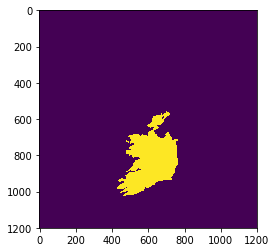

In [28]:
filename = 'data/MCD15A2.A2012273.h17v03.005.2012297134400.hdf'

# a layer (doesn't matter so much which: use for geometry info)
layer = 'Lai_1km'
# the full dataset specification
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
file_spec = file_template % ( filename, layer)

M = rasterise_vector ( file_spec, "data/ne_50m_admin_0_countries.shp", 
                  "NAME='Ireland'", verbose=False)
plt.imshow(M, interpolation="nearest")


This is available as [python/raster_mask.py](python/raster_mask.py).

Most of the code below should be familiar from above (we make use of the `getLAI()` function we developed).

Done!


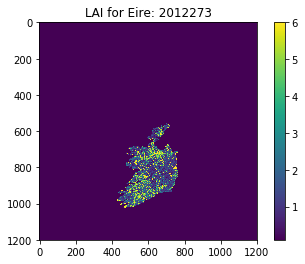

In [31]:
from raster_mask import getLAI


# the data file name
filename = 'data/MCD15A2.A2012273.h17v03.005.2012297134400.hdf'

# a layer (doesn't matter so much which: use for geometry info)
layer = 'Lai_1km'
# the full dataset specification
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
file_spec = file_template%(filename,layer)

mask = rasterise_vector ( file_spec, "data/ne_50m_admin_0_countries.shp", 
                  "NAME='Ireland'", verbose=False)
plt.imshow(mask)
# get the LAI data
data = getLAI(filename)

# reset the data mask
# 'mask' is True for Ireland
# so take the opposite 
data['Lai_1km'] = ma.array(data['Lai_1km'], mask=np.logical_not(mask))
data['LaiStdDev_1km'] = ma.array(data['Lai_1km'], mask=np.logical_not(mask))

plt.title('LAI for Eire: 2012273')
plt.imshow(data['Lai_1km'],vmax=6)
plt.colorbar()

## Exercise 4.3

Apply the concepts above to generate a 3D masked numpy data array of LAI and std LAI for Eire for the year 2012.

Plot your results and make a move of LAI.

Plot average LAI for Eire as a function of day of year for 2012.

# Summary

In this session, we have learned to use some geospatial tools using GDAL in Python. A good set of [working notes on how to use GDAL](http://jgomezdans.github.io/gdal_notes/) has been developed that you will find useful for further reading, as well as looking at the [advanced](advanced.ipynb) section.

We have also very briefly introduced dealing with vector datasets in `ogr`, but this was mainly through the use of a pre-defined function that will take an ESRI shapefile (vector dataset), warp this to the projection of a raster dataset, and produce a mask for a given layer in the vector file.

If there is time in the class, we will develop some exercises to examine the datasets we have generated and/or to explore some different datasets or different locations.
